<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Algorithms" data-toc-modified-id="1.-Algorithms-2">1. Algorithms</a></span><ul class="toc-item"><li><span><a href="#1.1-Augmented-Lagrangian-+-Conjugate-Gradient" data-toc-modified-id="1.1-Augmented-Lagrangian-+-Conjugate-Gradient-2.1">1.1 Augmented Lagrangian + Conjugate Gradient</a></span></li><li><span><a href="#1.2-Improved-Augmented-Lagrangian" data-toc-modified-id="1.2-Improved-Augmented-Lagrangian-2.2">1.2 Improved Augmented Lagrangian</a></span></li><li><span><a href="#1.3-Proximal-Gradient-Methods" data-toc-modified-id="1.3-Proximal-Gradient-Methods-2.3">1.3 Proximal Gradient Methods</a></span></li></ul></li><li><span><a href="#2.-Operators" data-toc-modified-id="2.-Operators-3">2. Operators</a></span></li><li><span><a href="#3.-Helper-functions" data-toc-modified-id="3.-Helper-functions-4">3. Helper functions</a></span></li><li><span><a href="#4.-PINCAT-phantom-example" data-toc-modified-id="4.-PINCAT-phantom-example-5">4. PINCAT phantom example</a></span><ul class="toc-item"><li><span><a href="#4.1-Preparation" data-toc-modified-id="4.1-Preparation-5.1">4.1 Preparation</a></span></li><li><span><a href="#4.2-Test-algorithms" data-toc-modified-id="4.2-Test-algorithms-5.2">4.2 Test algorithms</a></span></li></ul></li><li><span><a href="#5.-Multicoil-cardiac-cine-MRI" data-toc-modified-id="5.-Multicoil-cardiac-cine-MRI-6">5. Multicoil cardiac cine MRI</a></span><ul class="toc-item"><li><span><a href="#5.1-Preparation" data-toc-modified-id="5.1-Preparation-6.1">5.1 Preparation</a></span></li><li><span><a href="#5.2-Test-algorithms" data-toc-modified-id="5.2-Test-algorithms-6.2">5.2 Test algorithms</a></span></li></ul></li><li><span><a href="#6.-Multicoil-cardiac-perfusion-MRI" data-toc-modified-id="6.-Multicoil-cardiac-perfusion-MRI-7">6. Multicoil cardiac perfusion MRI</a></span><ul class="toc-item"><li><span><a href="#6.1-Preparation" data-toc-modified-id="6.1-Preparation-7.1">6.1 Preparation</a></span></li><li><span><a href="#6.2-Test-algorithms" data-toc-modified-id="6.2-Test-algorithms-7.2">6.2 Test algorithms</a></span></li></ul></li><li><span><a href="#7.-Multicoil-abdominal-dce-MRI" data-toc-modified-id="7.-Multicoil-abdominal-dce-MRI-8">7. Multicoil abdominal dce MRI</a></span><ul class="toc-item"><li><span><a href="#7.1-Preparation" data-toc-modified-id="7.1-Preparation-8.1">7.1 Preparation</a></span></li><li><span><a href="#7.2-Test-algorithms" data-toc-modified-id="7.2-Test-algorithms-8.2">7.2 Test algorithms</a></span></li></ul></li></ul></div>

In [44]:
using MAT
using Plots
using MIRT
using LinearAlgebra
using FFTW
using LinearMaps
using OffsetArrays
using IterativeSolvers
using BenchmarkTools
include("helper_functions.jl");

In [5]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/JuliaSmoothOptimizers/Krylov.jl.git"))
Pkg.rm("Krylov")

    Cloning git-repo `https://github.com/JuliaSmoothOptimizers/Krylov.jl.git`


    g: [========================================>]  100.0 %4.6 %Fetching: [=======>                                 ]  15.7 %Fetching: [=======>                                 ]  16.3 %                           ]  30.8 % [===================>                     ]  45.5 % %              ]  64.6 % [================================>        ]  79.2 %>  ]  93.7 %

   Updating git-repo `https://github.com/JuliaSmoothOptimizers/Krylov.jl.git`


Fetching: [========================================>]  99.9 %=========>                               ]  21.0 %                             ]  25.5 % [===================>                     ]  46.6 %67.4 %>    ]  88.4 % %

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `~/mri/reproduce-l-s-dynamic-mri-julia/Project.toml`
  [ba0b0d4f] + Krylov v0.5.1 #master (https://github.com/JuliaSmoothOptimizers/Krylov.jl.git)
   Updating `~/mri/reproduce-l-s-dynamic-mri-julia/Manifest.toml`
  [9aa1b823] + FastClosures v0.3.2
  [ba0b0d4f] + Krylov v0.5.1 #master (https://github.com/JuliaSmoothOptimizers/Krylov.jl.git)
  [5c8ed15e] + LinearOperators v1.1.0
  [a759f4b9] + TimerOutputs v0.5.5


In [96]:
import Krylov

┌ Info: Precompiling Krylov [ba0b0d4f-ebba-5204-a429-3ac8c609bfb7]
└ @ Base loading.jl:1260


# 1. Algorithms
All the algorithms below are described in [this paper](https://web.eecs.umich.edu/~fessler/papers/files/jour/19/web/lin-19-edp.pdf) by Claire Yilin Lin, and Jeffrey A. Fessler, and based on their [original implementation in Matlab](https://github.com/JeffFessler/reproduce-l-s-dynamic-mri).

In [6]:
vectorize = v -> @view v[:]

#16 (generic function with 1 method)

## 1.1 Augmented Lagrangian + Conjugate Gradient

**Problem formulation:** $argmin_{L,S}min_{U,W}\{\frac{1}{2}\lVert \textbf{E}(L+S) -d \lVert_2^2 + \lambda_L \lVert P \lVert_* + \lambda_S \lVert Q \lVert_1\} \textrm{ subject to } \begin{cases} P = L \\ Q = \textbf{T}S \end{cases}$

**Modified AL function:** $\frac{1}{2}\lVert \textbf{E}(L+S) - d \lVert_2^2 + \lambda_L \lVert P \lVert_* + \lambda_S \lVert Q \lVert_1\ + \frac{\delta_1}{2} \lVert L - P + V_1 \lVert_2^2 + \frac{\delta_2}{2} \lVert \textbf{T}S - Q + V_2 \lVert_2^2$

**Inputs:**

 - $d$: under-sampled multi-coil k-t data
 - $\textbf{E}$: Acquisition operator
 - $\textbf{T}$: temporal Fourier tranform
 - $\lambda_L$: singular value threshold
 - $\lambda_S$: sparsity threshold
 - $iterL$: number of conjugate gradient iteration steps for $S$
 - $iterL$: number of conjugate gradient iteration steps for $L$
 - $\delta_1$, $\delta_2$: AL penalty parameters
 - $N$: number of iterations
 
**Initialization:** $L_0 = \textbf{E}^∗ d$, $S_0 = V_{1,0} = V_{2,0} = 0$

for $k = 1, 2, ... , N$ do
 - $P_k \leftarrow \textbf{SVT}_{\lambda_L / \delta_1} (L+V_2)$
 - $Q_k \leftarrow \textbf{T}^* \Lambda_{\lambda_S / \delta_2} (\textbf{T}S) + V_2 $
 - $L_k \leftarrow CG_{solver}\{\textrm{get } x \textrm{ s.t. } (\textbf{E}^*\textbf{E} + \delta_1\textbf{I})x = x_0 - \textbf{E}^*\textbf{E}S + \delta_1(P-V_1) \textrm{ starting from }L_{k-1}\}$,<br> where $x_0 = \textbf{E}^∗ d$ and $CG_{solver}$ is an iterative solver for conjugate gradient method
 - $S_k \leftarrow CG_{solver}\{\textrm{get } x \textrm{ s.t. } (\textbf{E}^*\textbf{E} + \delta_2\textbf{I})x = x_0 - \textbf{E}^*\textbf{E}L + \delta_2(Q-V_2) \textrm{ starting from }S_{k-1}\}$,<br> where $x_0 = \textbf{E}^∗ d$ and $CG_{solver}$ is an iterative solver for conjugate gradient method
 - $V_{1,k} \leftarrow V_{1,k-1} + L_k - P$
 - $V_{2,k} \leftarrow V_{2,k-1} + \textbf{T}S_k - Q$

end for

**output:** $L_N, S_N$ 

Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/algorithms/AL_CG.m

In [93]:
function AL_CG(d::AbstractArray,              # under-sampled k-t data
        E::LinearMap,                         # acquisition operator
        T::LinearMap;                         # temporal Fourier tranform
        img_shape::NTuple = size(d),          # size of output image
        scale_L::Real = 1,                    # scaling factor for L
        scale_S::Real = 1,                    # scaling factor for S
        λ_L::Real = 0.01,                     # singular value threshold
        λ_S::Real = 0.05,                     # sparsity threshold
        δ₁::Real = 1//10,                     # first AL penalty parameter
        δ₂::Real = 1//100,                    # second AL penalty parameter
        iterL::Int = 3,                       # number of CG iteration steps for S
        iterS::Int = iterL,                   # number of CG iteration steps for L
        N::Int = 10,                          # number of iterations
        verbose::Bool = false)                # print rank and loss value in each iteration
    
    complexType = eltype(d)
    floatType = real(complexType)
    
    scale_L, scale_S, λ_L, λ_S, δ₁, δ₂ = convert(floatType, scale_L), convert(floatType, scale_S),
        convert(floatType, λ_L), convert(floatType, λ_S), convert(floatType, δ₁), convert(floatType, δ₂)
    
    #Initialize
    @assert 3 ≤ length(img_shape) ≤ 4
    if length(img_shape) == 3
        nx,ny,nt = img_shape
        nc = size(d)[end]
    else
        nx,ny,nt,nc = img_shape
    end
    x₀ = reshape(E' * vectorize(d), nx*ny, nt) # initial guess
    L, S = x₀, zeros(complexType, size(x₀))
    V₁, V₂ = zeros(complexType, size(L)), zeros(complexType, size(L))

    cost = getCost(E, T, d, λ_L, λ_S, size(L), complexType)
    cost_vec = OffsetVector{floatType}(undef, 0:N)
    rank_vec = OffsetVector{floatType}(undef, 0:N)
    cost_vec[0] = cost(L, S)
    rank_vec[0] = rank(L)
    verbose && println("k = 0, rank = $(rank_vec[0]), cost = $(cost_vec[0])")
    
    cg_tol = convert(floatType, 1e-5)
    
    P, Q = similar(L), similar(L)
    temp₁, temp₂ = similar(L), similar(L)
    
    # Iteration
    cg_op₁, cg_op₂ = E'*E + δ₁*I, E'*E + δ₂*I
    EᴴE_op = E'*E
    for k in 1:N
        P = SVT!(P .= L .+ V₁, scale_L * λ_L / δ₁)
        Q_temp = mul!(vectorize(Q), T, vectorize(S))
        Q = Λ!(reshape(reshape(Q_temp, size(Q)...) .+= V₂, nx*ny, nt), scale_S * λ_S / δ₂)
        mul!(vectorize(temp₁), EᴴE_op, vectorize(S))
        temp₁ .= x₀ .- temp₁ .+ δ₁.*(temp₂ .= P .- V₁)
        L = cg!(vectorize(L), cg_op₁, vectorize(temp₁), tol=cg_tol, maxiter=iterL)
        L = reshape(L, nx*ny, nt)
        mul!(vectorize(temp₂), T', vectorize(temp₁ .= Q .- V₂))
        mul!(vectorize(temp₁), EᴴE_op, vectorize(L))
        temp₁ .= x₀ .- temp₁ .+ δ₂.*temp₂
        S = cg!(vectorize(S), cg_op₂, vectorize(temp₁), tol=cg_tol, maxiter=iterL)
        S = reshape(S, nx*ny, nt)
        V₁ .+= L .- P
        mul!(vectorize(temp₁), T, vectorize(S))
        V₂ .+= temp₁ .- Q
        
        cost_vec[k] = cost(L, S)
        rank_vec[k] = rank(L)
        verbose && println("k = $k, rank = $(rank_vec[k]), cost = $(cost_vec[k])")
    end
    
    reshape(L, nx, ny, nt), reshape(S, nx, ny, nt), rank_vec, cost_vec
end

AL_CG (generic function with 1 method)

## 1.2 Improved Augmented Lagrangian

**Problem formulation:** $argmin_{L,S}min_{Z,X}\{\frac{1}{2}\lVert \boldsymbol{\Omega} Z -d \lVert_2^2 + \lambda_L \lVert L \lVert_* + \lambda_S \lVert \textbf{T}S \lVert_1\} \textrm{ subject to } \begin{cases} Z = \textbf{QC}X \\ X = L+S \end{cases}$

**Modified AL function:** $\frac{1}{2}\lVert \boldsymbol{\Omega} Z -d \lVert_2^2 + \lambda_L \lVert L \lVert_* + \lambda_S \lVert \textbf{T}S \lVert_1 + \frac{\delta_1}{2} \lVert Z - \textbf{QC} + V_1 \lVert_2^2 + \frac{\delta_2}{2} \lVert X - (L+S) + V_2 \lVert_2^2$

**Inputs:**
 - $d$: under-sampled multi-coil k-t data
 - $\boldsymbol{\Omega}$: under-sampling mask
 - $\textbf{Q}$: Fourier encoding operator
 - $\textbf{C}$: coil sensitivity maps
 - $\textbf{T}$: temporal Fourier tranform
 - $\lambda_L$: singular value threshold
 - $\lambda_S$: sparsity threshold
 - $\delta_1$, $\delta_2$: AL penalty parameters
 - $N$: number of iterations
 
**Initialization:** $X_0 = L_0 = C∗Q∗Ω∗d$, $S_0 = V_{1,0} = V_{2,0} = 0$

for $k = 1, 2, ... , N$ do
 - $Z_k \leftarrow argmin_Z \frac{1}{2} \lVert\boldsymbol{\Omega} Z-d\lVert_2^2 + \frac{\delta_1}{2}\lVert X - (L+S) + V_2\lVert_2^2 = (\boldsymbol{\Omega}^*\boldsymbol{\Omega} + \delta_1 \textbf{I})^{-1}(\boldsymbol{\Omega}^*d + \delta_1(\textbf{Q}\textbf{C}X - V_1))$
 - $X_k \leftarrow argmin_X \frac{\delta_1}{2} \lVert Z-\textbf{QC}X+V\_1 \lVert_2^2 + \frac{\delta_2}{2} \lVert X-(L+S) + V_2 \lVert_2^2$ $ = (\textbf{C}^*\textbf{C} + \frac{\delta_1}{\delta_2}\textbf{I})^{-1}(\textbf{C}^*\textbf{Q}^*(Z+V_1)+\frac{\delta_1}{\delta_2}(L+S+V_2)) = \frac{\delta_1}{\delta_1+\delta_2}(\textbf{C}^*\textbf{Q}^*(Z+V_1) + \frac{\delta_2}{\delta_1}(L+S-V_2))$
 - $L_k \leftarrow argmin_L (\lambda_L \lVert L \lVert_* + \frac{\delta_2}{2} \lVert X - (L + S) + V_2 \lVert_2^2) = \textbf{SVT}_{\lambda_L / \delta_2} (X-S+V_2)$
 - $S_k \leftarrow argmin_S (\lambda_S \lVert \textbf{T} S \lVert_1 + \frac{\delta_2}{2} \lVert X - (L + S) + V_2 \lVert_2^2)$ $ = \textbf{T}^* (argmin_S (\lambda_S \lVert \tilde{S} \lVert_1 + \frac{\delta_2}{2} \lVert \textbf{T}(X - (L + S) + V_2) - \tilde{S} \lVert_2^2)$ $ = \textbf{T}^* \Lambda_{\lambda_S / \delta_2} (\textbf{T}(X - L + V_2)) $ where $\tilde{S} = \textbf{T}S$
 - $V_{1,k} \leftarrow V_{1,k-1} + (Z_k − \textbf{QC}X_k)$
 - $V_{2,k} \leftarrow V_{2,k-1} + X_k − (L_k + S_k)$

end for

**output:** $L_N, S_N$ 

Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/algorithms/AL_2.m

In [ ]:
function AL_2(d::AbstractArray,               # under-sampled k-t data
        Ω::LinearMap,                         # under-sampling mask
        Q::LinearMap,                         # Fourier encoding operator
        C::LinearMap,                         # coil sensitivity maps
        T::LinearMap;                         # temporal Fourier tranform
        img_shape::NTuple = size(d),          # size of output image
        scale_L::Real = 1,                    # scaling factor for L
        scale_S::Real = 1,                    # scaling factor for S
        λ_L::Real = 0.01,                     # singular value threshold
        λ_S::Real = 0.05,                     # sparsity threshold
        δ₁::Real = 1//10,                     # first AL penalty parameter
        δ₂::Real = 1//100,                    # second AL penalty parameter
        N::Int = 10,                          # number of iterations
        verbose::Bool = false)                # print rank and loss value in each iteration
    
    complexType = eltype(d)
    floatType = real(complexType)
    
    scale_L, scale_S, λ_L, λ_S, δ₁, δ₂ = convert(floatType, scale_L), convert(floatType, scale_S),
        convert(floatType, λ_L), convert(floatType, λ_S), convert(floatType, δ₁), convert(floatType, δ₂)
    
    #Initialize
    @assert 3 ≤ length(img_shape) ≤ 4
    if length(img_shape) == 3
        nx,ny,nt = img_shape
        nc = size(d)[end]
    else
        nx,ny,nt,nc = img_shape
    end
    E = Ω * Q * C
    L = reshape(E' * vectorize(d), nx*ny, nt) # initial guess
    S = zeros(complexType, size(L))
    X = L + S
    V₁ = zeros(complexType, size(d))
    V₂ = zeros(complexType, size(L))
    Z_scaler = repeat(1 ./ (samp .+ δ₁), 1, 1, 1, nc) # equivalent to (Ω'*Ω + δ₁*I)'
    
    cost_vec = OffsetVector{floatType}(undef, 0:N)
    rank_vec = OffsetVector{floatType}(undef, 0:N)
    cost_vec[0] = cost(L, S, d, scale_L*λ_L, scale_S*λ_S)
    rank_vec[0] = rank(L)
    verbose && println("k = 0, rank = $(rank_vec[0]), cost = $(cost_vec[0])")
    
    Z = similar(L)
    
    # Iteration
    for k in 1:N
        Z .= Z_scaler .* reshape(Ω'*d[:] + δ₁*(Q*C*X[:] - V₁[:]), nx, ny, nt, nc)
        X = δ₁/(δ₁+δ₂)*reshape(C'*Q'*(Z + V₁)[:],nx*ny,nt) + δ₂/(δ₁ + δ₂)*(L + S - V₂)
        L = SVT(X - S + V₂, scale_L * λ_L / δ₂)
        S = reshape(T' * Λ(reshape(T * (X - L + V₂)[:], nx*ny, nt), scale_S * λ_S / δ₂)[:], nx*ny, nt)
        V₁ += Z - reshape(Q*C*X[:], nx,ny,nt,nc)
        V₂ += X - L - S
        
        cost_vec[k] = cost(L, S, d, scale_L*λ_L, scale_S*λ_S)
        rank_vec[k] = rank(L)
        verbose && println("k = $k, rank = $(rank_vec[k]), cost = $(cost_vec[k])")
    end
    
    reshape(L, nx, ny, nt), reshape(S, nx, ny, nt), rank_vec, cost_vec
end

## 1.3 Proximal Gradient Methods

**Inputs:**

 - $d$: under-sampled k-t data
 - $\textbf{E}$: data acquisition operator
 - $\textbf{T}$: temporal Fourier transform
 - $\lambda_L$: singular value threshold
 - $\lambda_S$: sparsity threshold
 - $N$: number of iterations
 - $momentum$: update rule (ISTA/FISTA/POGM)
 
**Initialization:** $M_0 = L_0 = \tilde{L}_0 = \bar{L}_0 = E∗d, S_0 = 0, \theta_0 = \zeta_0 = 1, t = 0.5 \textrm{ (for FISTA and POGM) or } 0.99 \textrm{ (for ISTA)}$

for $k = 1, 2, ... , N$ do

 - $\tilde{L}_k \leftarrow M_{k-1} - S_{k-1}$
 - $\tilde{S}_k \leftarrow M_{k-1} - L_{k-1}$
 - $\theta_k \leftarrow \begin{cases} \frac{1+\sqrt{1 + 4\theta_{k-1}^2}}{2} \\ \frac{1+\sqrt{1 + 8\theta_{k-1}^2}}{2} \end{cases}$
 - $\bar{X}_k \leftarrow \begin{cases} \tilde{X}_k : momentum = ISTA \\ \tilde{X}_k + \frac{\theta_{k-1}-1}{\theta_k}(\tilde{X}_k - \tilde{X}_{k-1}) + \frac{\theta_{k-1}}{\theta_k}(\tilde{X}_k - X_{k-1}) : momentum = FISTA \\ \tilde{X}_k + \frac{\theta_{k-1}-1}{\theta_k}(\tilde{X}_k - \tilde{X}_{k-1}) + \frac{\theta_{k-1}}{\theta_k}(\tilde{X}_k - X_{k-1}) + \frac{\theta_{k-1}-1}{\zeta_{k-1} \theta_k}(\bar{X}_{k-1} - X_{k-1}) : momentum = POGM \end{cases}$
 - $\zeta_k \leftarrow t(1+\frac{\theta_{k-1}-1}{\theta_k} + \frac{\theta_{k-1}}{\theta_k})$
 - $L_k \leftarrow \textbf{SVT}_{\lambda_L}(\bar{L}_k)$
 - $S_k \leftarrow \textbf{T}^*(\Lambda_{\lambda_S}[\textbf{T}(\bar{S}_k)])$
 - $M_k \leftarrow L_k + S_k - t\textbf{E}^* (\textbf{E}(L_k +S_k)-d)$

end for

**output:** $X_N$

This funciton creates the following construct: $X = \begin{bmatrix}L \\ S\end{bmatrix}$ in such a way that modifying $L$ or $S$ also takes effect in $X$, and vice versa.

In [ ]:
function createXLS(dType, row_dim, nt)
    X = zeros(dType, row_dim, 2*nt)
    L = view(X, :, 1:nt)
    S = view(X, :, nt + 1:2*nt)
    return X,L,S
end
function allocate(dType, row_dim, nt)
    createXLS(dType, row_dim, nt)..., createXLS(dType, row_dim, nt)...
end

Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/algorithms/PGM.m

In [ ]:
function PGM(d::AbstractArray,              # under-sampled k-t data
        E::LinearMap,                       # acquisition operator
        T::LinearMap;                       # sparsifying operator
        img_shape::NTuple = size(d),        # size of output image
        scale_L::Real = 1,                  # scaling factor for L
        scale_S::Real = 1,                  # scaling factor for S
        tscale::Real = 1,                   # scaling factor for t
        λ_L::Real = 0.01,                   # singular value threshold
        λ_S::Real = 0.05,                   # sparsity threshold
        N::Int = 10,                        # number of iterations
        restart::Bool = true,               # reset θₖ if cost increased
        momentum::Symbol = :pogm,           # update rule (:pogm, :ista, :fista)
        verbose::Bool = false)              # print rank and loss value in each iteration
    
    complexType = eltype(d)
    floatType = real(complexType)
    
    scale_L, scale_S, tscale, λ_L, λ_S = convert(floatType, scale_L), convert(floatType, scale_S),
        convert(floatType, tscale), convert(floatType, λ_L), convert(floatType, λ_S)
    
    #Initialize
    @assert 3 ≤ length(img_shape) ≤ 4
    if length(img_shape) == 3
        nx,ny,nt = img_shape
        nc = size(d)[end]
    else
        nx,ny,nt,nc = img_shape
    end
    x₀ = E' * d[:] # initial guess
    row_dim = nx*ny
    
    Xₖ₋₁,Lₖ₋₁,Sₖ₋₁,Xₖ,Lₖ,Sₖ = allocate(complexType, row_dim, nt)
    X̃ₖ₋₁,L̃ₖ₋₁,S̃ₖ₋₁,X̃ₖ,L̃ₖ,S̃ₖ = allocate(complexType, row_dim, nt)
    X̄ₖ₋₁,L̄ₖ₋₁,S̄ₖ₋₁,X̄ₖ,L̄ₖ,S̄ₖ = allocate(complexType, row_dim, nt)
    Lₖ₋₁ .= reshape(x₀, row_dim, nt)
    X̄ₖ₋₁ .= X̃ₖ₋₁ .= Xₖ₋₁
    
    t = (in(momentum, (:fista, :pogm)) ? 5//10 : 99//100) * tscale
    Mₖ₋₁ = reshape(x₀[:] - t*E' * (E * x₀[:] - d)[:], row_dim, nt)
    θₖ₋₁ = ζₖ₋₁ = 1.
    
    cost_vec = OffsetVector{floatType}(undef, 0:N)
    rank_vec = OffsetVector{floatType}(undef, 0:N)
    cost_vec[0] = cost(L, S, d, scale_L*λ_L, scale_S*λ_S)
    rank_vec[0] = rank(L)
    verbose && println("k = 0, rank = $(rank_vec[0]), cost = $(cost_vec[0])")
    
    # Iteration
    for k in 1:N
        L̃ₖ .= Mₖ₋₁ .- Sₖ₋₁
        S̃ₖ .= Mₖ₋₁ .- Lₖ₋₁
        θₖ  = (1 + √(1 + (k < N ? 4 : 8)*θₖ₋₁^2))/2
        if momentum == :pogm
            @. X̄ₖ = X̃ₖ + (θₖ₋₁-1)/θₖ*(X̃ₖ - X̃ₖ₋₁) +
                (θₖ₋₁)/θₖ*(X̃ₖ - Xₖ₋₁) + (θₖ₋₁-1)/(ζₖ₋₁*θₖ)*t*(X̄ₖ₋₁ - Xₖ₋₁)
        elseif momentum == :fista
            @. X̄ₖ = X̃ₖ + (θₖ₋₁-1)/θₖ*(X̃ₖ - X̃ₖ₋₁)
        else
            @. X̄ₖ = X̃ₖ
        end
        ζₖ  = t*(1 + (θₖ₋₁-1)/θₖ + (θₖ₋₁)/θₖ)
        Lₖ .= SVT(L̄ₖ, scale_L*λ_L)
        Sₖ .= reshape(T' * Λ(T * S̄ₖ[:], scale_S*λ_S)[:], row_dim, nt)
        Mₖ = Lₖ + Sₖ - reshape(t * E' * (E * (Lₖ + Sₖ)[:] - d)[:], row_dim, nt)
        
        cost_vec[k] = cost(L, S, d, scale_L*λ_L, scale_S*λ_S)
        rank_vec[k] = rank(L)
        verbose && println("k = $k, rank = $(rank_vec[k]), cost = $(cost_vec[k])")
        
        if restart && cost_vec[k] > cost_vec[k - 1]
            θₖ₋₁ = θₖ = convert(floatType, 1)
            verbose && println("   Restarted!")
        end
        
        # Move (k) -> (k-1), and avoid allocation for new (k)
        #      => switch (k) and (k-1) matrices
        @swap(Xₖ₋₁, Xₖ); @swap(X̃ₖ₋₁, X̃ₖ); @swap(X̄ₖ₋₁, X̄ₖ)
        @swap(Lₖ₋₁, Lₖ); @swap(L̃ₖ₋₁, L̃ₖ); @swap(L̄ₖ₋₁, L̄ₖ)
        @swap(Sₖ₋₁, Sₖ); @swap(S̃ₖ₋₁, S̃ₖ); @swap(S̄ₖ₋₁, S̄ₖ)
        @swap(Mₖ₋₁, Mₖ)
        θₖ₋₁, ζₖ₋₁ = θₖ, ζₖ
    end
    
    reshape(Lₖ, nx, ny, nt), reshape(Sₖ, nx, ny, nt), rank_vec, cost_vec
end

# 2. Operators
**All-in-one acquisition operator**

In [ ]:
FFTW.set_num_threads(48)

In [24]:
function getE(nx::Int, ny::Int, nt::Int, nc::Int, samp::AbstractArray{T,3} where T,
        smap::AbstractArray{Complex{T},3} where T, dType::Type)
    mask = repeat(samp, 1, 1, 1, nc) .== 1
    reshaped_smap = reshape(convert.(dType, smap), nx, ny, 1, nc)
    xcoils₁ = Array{dType}(undef, nx, ny, nt, nc)
    xcoils₂ = Array{dType}(undef, nx, ny, nt, nc)
    FFT_plan = plan_fft!(xcoils₁, (1,2))
    iFFT_plan = inv(FFT_plan)
    LinearMap{dType}(
        (b, x) -> begin # Don't ask me, why did Mr Otazo use ifft instead of fft...
                xcoils₁ .= reshape(x, nx, ny, nt, 1) .* reshaped_smap
                ifftshift!(xcoils₂, xcoils₁, (1, 2))
                iFFT_plan * xcoils₂
                fftshift!(xcoils₁, xcoils₂, (1, 2))
                reshape(b, nx, ny, nt, nc) .= xcoils₁ .* mask
                b
            end,
        (b, y) -> begin # But he used it consistently, so it doesn't make a big difference
                ifftshift!(xcoils₂, reshape(y, nx, ny, nt, nc), (1, 2))
                FFT_plan * xcoils₂
                fftshift!(xcoils₁, xcoils₂, (1, 2))
                xcoils₁ .*= conj.(reshaped_smap)
                sum!(reshape(b, nx, ny, nt, 1), xcoils₁)
                b
            end,
        nx*ny*nt*nc, nx*ny*nt)
end

getE (generic function with 1 method)

**Components of acquisition operator separately**

In [47]:
function getΩQC(nx::Int, ny::Int, nt::Int, nc::Int, samp::AbstractArray{T,3} where T,
        smap::AbstractArray{Complex{T},3} where T, dType::Type)
    mask = repeat(samp, 1, 1, 1, nc) .== 1
    reshaped_smap = reshape(convert.(dType, smap), nx, ny, 1, nc)
    xcoils = Array{dType}(undef, nx, ny, nt, nc)
    FFT_plan = plan_fft!(xcoils, (1,2))
    iFFT_plan = inv(FFT_plan)
    C = LinearMap{dType}(
        (b, x) -> begin
                reshape(b, nx, ny, nt, nc) .= reshape(x, nx, ny, nt, 1) .* reshaped_smap
                b
            end,
        (b, y) -> begin
                xcoils .= y .* conj.(reshaped_smap)
                sum!(reshape(b, nx, ny, nt, 1), xcoils)
                b
            end,
        nx*ny*nt*nc, nx*ny*nt)
    Q = LinearMap{dType}(
        (b, x) -> begin
                ifftshift!(xcoils, reshape(x, nx, ny, nt, nc), (1, 2))
                iFFT_plan * xcoils
                fftshift!(reshape(b, nx, ny, nt, nc), xcoils, (1, 2))
                b
            end,
        (b, y) -> begin
                ifftshift!(xcoils, reshape(y, nx, ny, nt, nc), (1, 2))
                FFT_plan * xcoils
                fftshift!(reshape(b, nx, ny, nt, nc), xcoils, (1, 2))
                b
            end,
        nx*ny*nt*nc, nx*ny*nt*nc)
    Ω = LinearMap{dType}(
        (b, x) -> reshape(b, nx, ny, nt, nc) .= reshape(x, nx, ny, nt, nc) .* mask,
        (b, y) -> b .= y,
        nx*ny*nt*nc, nx*ny*nt*nc)
    return Ω, Q, C
end

getΩQC (generic function with 1 method)

**Acquisition operator with non-uniform FFT**

Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/operators/getEnufft.m

`E_basis` function is found in `helper_functions.jl`

`nufft_plan` is basically the simplified and memory-optimized version of `nufft_init` from `MIRT`.

In [30]:
function nufft_plan(w::AbstractMatrix{<:Real}, N::Dims;
        n_shift::AbstractVector{<:Real} = zeros(Int, length(N)),
        nfft_m::Int = 4,
        nfft_sigma::Real = 1.25,
        pi_error::Bool = true)

    any(N .< 6) && throw("NFFT may be erroneous for small N")
    any(isodd.(N)) && throw("NFFT erroneous for odd N")
    pi_error && any(abs.(w) .> π) && throw(ArgumentError("|w| > π is likely an error"))

    M,D = size(w)
    length(N) != D && throw(DimensionMismatch("length(N) vs D=$D"))
    length(n_shift) != D && throw(DimensionMismatch("length(n_shift) vs D=$D"))

    T = nufft_eltype(w)
    CT = Complex{T}
    f = convert.(T, w/(2π)) # note: NFFTPlan must have correct type
    p = NFFTPlan(f', N, nfft_m, nfft_sigma) # create plan

    # extra phase here because NFFT always starts from -N/2
    phasor = CT.(cis.(-w * (collect(N)/2. - n_shift)))
    phasor_conj = conj.(phasor)
    phasor_buffer = similar(phasor_conj)
    forw = (b, x) -> b .= nfft!(p, MIRT.nufft_typer(CT, x), b) .* phasor
    back = (b, y) -> nfft_adjoint!(p, nufft_typer(CT, phasor_buffer .= y .* phasor_conj), b)

    return (nufft=forw, nufft_adjoint=backw)
end

nufft_plan (generic function with 1 method)

In [31]:
function getEnufft(sense_maps::AbstractArray{Complex{T},3} where T; ksp::AbstractArray, om::AbstractArray,
        wi::Union{AbstractArray, Nothing} = nothing, dType::Type)
    
    nx,ny,nc = size(sense_maps)
    M,_,nt = size(ksp)
    n_shift = (nx, ny) .÷ 2
    
    sense_maps = convert.(dType, reshape(sense_maps, nx, ny, 1, nc))
    !(wi isa Nothing) && (wi = convert.(dType, wi))
    
    #basistransform = E_basis("dirac", M=M, nt=nt, fov=(22,22), N=(nx,ny), ksp=ksp)
    st = [nufft_plan(@view(om[:, :, tt]), (nx, ny), nfft_m=2, nfft_sigma=1.25, n_shift=collect(n_shift))
        for tt = 1:nt]
    
    xcoils = Array{dType}(undef, nx, ny, nt, nc)
    ksp_buffer = Array{dType}(undef, M, nt, nc)
    scaling = convert(dType, √(nx*ny))
    
    E = LinearMap{dType}(
        (b, x) -> begin
            xcoils .= reshape(x, nx, ny, nt, 1) .* sense_maps
            xcoilsₜ = similar(xcoils, nx, ny, nc)
            ksp = reshape(b, M, nt, nc)
            kspₜ = similar(b, M, nc)
            for tt=1:nt
                xcoilsₜ .= @view xcoils[:, :, tt, :]
                kspₜ = st[tt].nufft(kspₜ, xcoilsₜ)
                ksp[:, tt, :] .= kspₜ ./ scaling
            end
            #b .* basistransform
            b
        end,
        (b, y) -> begin
            ksp = reshape(y, M, nt, nc)
            ksp = wi isa Nothing ? ksp : ksp_buffer .= ksp .* wi
            kspₜ = similar(y, M, nc)
            xcoils = reshape(b, nx, ny, nt, nc)
            xcoilsₜ = similar(xcoils, nx, ny, nc)
            for tt=1:nt
                kspₜ .= @view ksp[:, tt, :]
                xcoilsₜ = st[tt].nufft_adjoint(xcoilsₜ, kspₜ)
                xcoils[:, :, tt, :] .= xcoilsₜ ./ scaling
            end
            #b .* basistransform
            b
        end,
        M*nt*nc, nx*ny*nt
    )
end

getEnufft (generic function with 1 method)

**Sparsifying transform**

A Fourier transform along the time dimension

In [90]:
function getT(nx::Int, ny::Int, nt::Int, dType::Type)
    buffer = Array{dType}(undef, nx, ny, nt)
    FFT_plan = plan_fft(buffer, 3)
    iFFT_plan = inv(FFT_plan)
    scaling = convert(dType, √(nt))
    LinearMap{dType}(
        (b, x) -> begin
            mul!(buffer, FFT_plan, reshape(x, nx, ny, nt))
            fftshift!(reshape(b, nx, ny, nt), buffer, 3)
            b ./= scaling
            end,
        (b, y) -> begin
            mul!(buffer, iFFT_plan, reshape(y, nx, ny, nt))
            ifftshift!(reshape(b, nx, ny, nt), buffer, 3)
            b .*= scaling
            end,
        nx*ny*nt, nx*ny*nt)
end

getT (generic function with 1 method)

# 3. Helper functions
**Thresholding**

In [22]:
pos(x) = x < 0 ? zero(x) : x
Λ! = (v,p) -> @. v = sign(v) * pos(abs(v) - p)

SVT!(A,p) = begin
    F = svd!(A)
    mul!(A, F.U, mul!(F.Vt, Diagonal(Λ!(F.S, p)), F.Vt))
end

SVT! (generic function with 1 method)

**Norms**

In [35]:
normₙ!(A) = sum(svdvals!(A))
norm₁(A) = norm(A, 1)
norm₂(A) = norm(A, 2)

norm₂ (generic function with 1 method)

**Cost function**

In [73]:
function getCost(E, T, d, λ_L, λ_S, LS_size, dType)
    buffer₁ = Array{dType}(undef, LS_size)
    buffer₂ = Array{dType}(undef, E.M)
    (L, S) -> begin
        buffer₁ .= L .+ S
        consistency = 1//2 * norm₂(buffer₂ .= mul!(buffer₂, E, vectorize(buffer₁)) .- vectorize(d))^2
        nuclear_norm = λ_L * normₙ!(buffer₁ .= L)
        l₁_norm = λ_S * norm₁(mul!(vectorize(buffer₁), T, vectorize(S)))
        consistency + nuclear_norm + l₁_norm
    end
end

getCost (generic function with 1 method)

# 4. PINCAT phantom example
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_PINCAT_phantom.m

## 4.1 Preparation

**Read data**

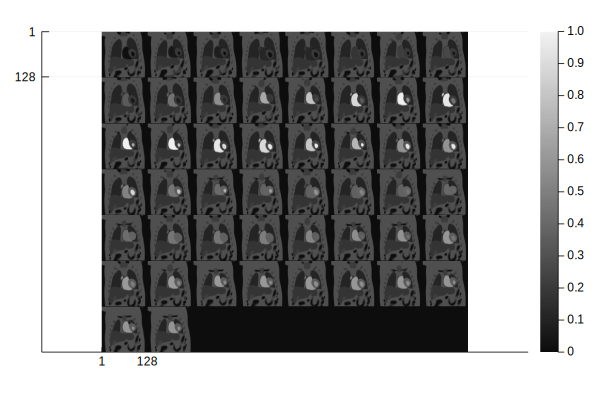

In [39]:
data = matread("../reproduce-l-s-dynamic-mri/data/aperiodic_pincat.mat")["new"]
Xtrue = convert.(Float32, permutedims(data, [2, 1, 3]) ./ maximum(data))
nx,ny,nt = size(Xtrue);
jim(Xtrue)

**Simulate coil maps**

`ir_mri_sensemap_sim` is part of MIRT.jl
 - https://github.com/JeffFessler/MIRT.jl/blob/master/src/mri/sensemap-sim.jl

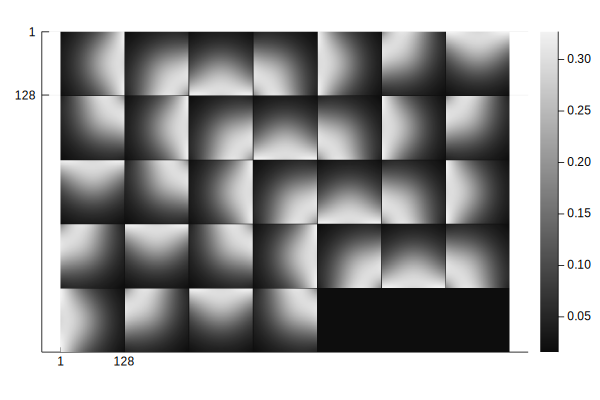

In [40]:
nc = 8;
nring = 4;
b1,_ = ir_mri_sensemap_sim(dims=(nx,ny), dx=1.5, dz=1.5,
    ncoil=nc*nring, nring=nring, rcoil=120, coil_distance=1.2, chat=false)
b1c = b1 ./ repeat(sqrt.(sum(abs2.(b1), dims=3)),outer=[1,1,nc*nring])
jim(b1c, abswarn=false)

**Coil compression to 8 coils**

MRI coil compression via PCA<br>
Given multiple MRI surface coil images (b1c), use SVD/PCA to find a smaller number of virtual coil images.

Function `ir_mri_coil_compress` is found in `helper_functions.jl`

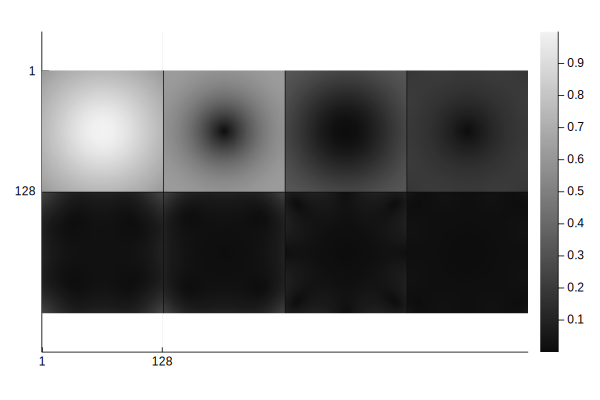

In [41]:
smap0,_,_ = ir_mri_coil_compress(b1c, ncoil=nc);
smap = smap0 ./ sqrt.(sum(abs2.(smap0), dims=3))
jim(smap, abswarn=false)

**Sampling mask**

Function `strucrand` is found in `helper_functions.jl`

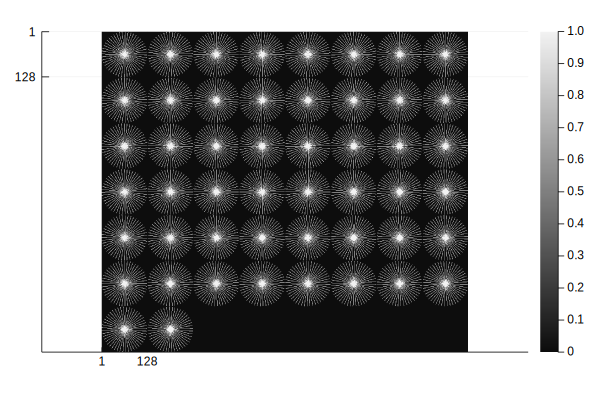

In [42]:
line = 24
samp = strucrand(nx, ny, nt, line)
pre_mask = fftshift(repeat(samp, 1, 1, 1, nc), 1:2)
mask = pre_mask .== 1
jim(samp)

**Acquisition operator and measured data**

In [45]:
E = getE(nx, ny, nt, nc, samp, smap, ComplexF64)
ytrue = reshape(E * Xtrue[:], nx, ny, nt, nc);

Get components of acquisition operator separately:

In [48]:
Ω, Q, C = getΩQC(nx, ny, nt, nc, samp, smap, ComplexF64)

(LinearMaps.FunctionMap{Complex{Float64}}(#100, #101, 6553600, 6553600; ismutating=true, issymmetric=false, ishermitian=false, isposdef=false), LinearMaps.FunctionMap{Complex{Float64}}(#98, #99, 6553600, 6553600; ismutating=true, issymmetric=false, ishermitian=false, isposdef=false), LinearMaps.FunctionMap{Complex{Float64}}(#96, #97, 6553600, 819200; ismutating=true, issymmetric=false, ishermitian=false, isposdef=false))

**Add noise and prepare for regularization scaling**

Add complex noise such that the $SNR = 46dB$

In [49]:
noise = randn(Float32, size(ytrue)) + randn(Float32, size(ytrue))im # complex noise!
snr_dB = 46
scale_noise = norm(ytrue) / norm(noise) / 10^(snr_dB / 20.f0)
y = ytrue + scale_noise * noise
rms(x) = norm(x-ytrue) / sqrt(length(x-ytrue))
snr(x) = 20 * log10(norm(ytrue) / norm(x-ytrue))
@show rms(y)
@show snr(y);

rms(y) = 3.3247648953529757e-6
snr(y) = 45.999999269030376


**Sparsifying transform**

A Fourier transform along the time dimension

In [91]:
T = getT(nx, ny, nt, ComplexF64)

LinearMaps.FunctionMap{Complex{Float64}}(#129, #130, 819200, 819200; ismutating=true, issymmetric=false, ishermitian=false, isposdef=false)

## 4.2 Test algorithms

Get scaling value required by all algorithms

In [61]:
x₀ = reshape(E' * vectorize(y), nx*ny, nt)
St = svdvals(x₀ - reshape(E' * (vectorize(E * vectorize(x₀)) - vectorize(y)), nx*ny, nt));

Run AL-CG

In [62]:
@benchmark L, S, j_rankL_cg, j_cost_cg =
    AL_CG(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, δ₁ = 1//2, δ₂ = 1//2)

MethodError: MethodError: no method matching (::var"#76#77"{LinearMaps.FunctionMap{Complex{Float64},var"#24#26"{Int64,Int64,Int64,Int64,BitArray{4},Array{Complex{Float64},4},Array{Complex{Float64},4},Array{Complex{Float64},4},AbstractFFTs.ScaledPlan{Complex{Float64},FFTW.cFFTWPlan{Complex{Float64},1,true,4},Float64}},var"#25#27"{Int64,Int64,Int64,Int64,BitArray{4},Array{Complex{Float64},4},Array{Complex{Float64},4},Array{Complex{Float64},4},FFTW.cFFTWPlan{Complex{Float64},-1,true,4}}},LinearMaps.FunctionMap{Complex{Float64},var"#72#74"{Int64,Int64,Int64,Array{Complex{Float64},3},FFTW.cFFTWPlan{Complex{Float64},-1,false,3},Complex{Float64}},var"#73#75"{Int64,Int64,Int64,Array{Complex{Float64},3},AbstractFFTs.ScaledPlan{Complex{Float64},FFTW.cFFTWPlan{Complex{Float64},1,false,3},Float64},Complex{Float64}}},Array{Complex{Float64},4},Float64,Float64,Array{Complex{Float64},2},Array{Complex{Float64},1}})(::Array{Complex{Float64},2}, ::Array{Complex{Float64},2}, ::Array{Complex{Float64},4}, ::Float64, ::Float64)
Closest candidates are:
  #76(::Any, ::Any) at In[37]:4

Run AL-2

In [ ]:
@benchmark L, S, j_rankL_al, j_cost_al =
    AL_2(y, Ω, Q, C, T, scale_L = maximum(St), scale_S = 1/1.887, δ₁ = 1//3, δ₂ = 1//10)

Run ISTA

In [ ]:
@benchmark L, S, j_rankL_ista, j_cost_ista =
    PGM(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, momentum=:ista)

Run FISTA

In [ ]:
@benchmark L, S, j_rankL_fista, j_cost_fista =
    PGM(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, momentum=:fista)

Run POGM

In [ ]:
@benchmark L, S, j_rankL_pogm, j_cost_pogm =
    PGM(y, E, T, scale_L = maximum(St), scale_S = 1/1.887, momentum=:pogm)

# 5. Multicoil cardiac cine MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_cardiac_cine.m

## 5.1 Preparation

**Read data**

In [ ]:
data = matread("../reproduce-l-s-dynamic-mri/data/cardiac_cine_R6.mat")
kdata, b1 = data["kdata"], data["b1"]
nx,ny,nt,nc = size(kdata)
b1c = b1 ./ sqrt.(sum(abs2, b1, dims=3))
jim(b1c, abswarn=false)

Sampling pattern:

In [ ]:
samp = kdata[:,:,:,1] .!= 0
jim(samp)

In [ ]:
E = getE(nx, ny, nt, nc, samp, b1c, ComplexF64)
Ω, Q, C = getΩQC(nx, ny, nt, nc, samp, b1c, ComplexF64)
T = getT(nx, ny, nt, ComplexF64)

## 5.2 Test algorithms

**Run AL-CG**

In [ ]:
@benchmark L, S, j_rankL_cg, j_cost_cg = AL_CG(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, δ₁ = 1//10, δ₂ = 1//20)

**Run AL-2**

In [ ]:
@benchmark L, S, j_rankL_al, j_cost_al = AL_2(kdata, Ω, Q, C, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, δ₁ = 1//10, δ₂ = 1//100)

**Run ISTA**

In [ ]:
@benchmark L, S, j_rankL_ista, j_cost_ista = PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:ista)

**Run FISTA**

In [ ]:
@benchmark L, S, j_rankL_fista, j_cost_fista = PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:fista)

**Run POGM**

In [ ]:
@benchmark L, S, j_rankL_pogm, j_cost_pogm = PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:pogm)

# 6. Multicoil cardiac perfusion MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_cardiac_perf.m

## 6.1 Preparation

**Read data**

In [ ]:
data = matread("../reproduce-l-s-dynamic-mri/data/cardiac_perf_R8.mat")
kdata, b1 = data["kdata"], data["b1"]
nx,ny,nt,nc = size(kdata)
b1c = b1 ./ sqrt.(sum(abs2, b1, dims=3))
jim(b1c, abswarn=false)

Sampling pattern:

In [ ]:
samp = kdata[:,:,:,1] .!= 0
jim(samp)

In [ ]:
E = getE(nx, ny, nt, nc, samp, b1c, ComplexF64)
Ω, Q, C = getΩQC(nx, ny, nt, nc, samp, b1c, ComplexF64)
T = getT(nx, ny, nt, ComplexF64)

## 6.2 Test algorithms

**Run AL-CG**

In [ ]:
@benchmark L, S, j_rankL_cg, j_cost_cg = AL_CG(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, δ₁ = 1/5., δ₂ = 1/5.)

**Run AL-2**

In [ ]:
@benchmark L, S, j_rankL_al, j_cost_al = AL_2(kdata, Ω, Q, C, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, δ₁ = 1/5., δ₂ = 1/50.)

**Run ISTA**

In [ ]:
@benchmark L, S, j_rankL_ista, j_cost_ista = PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:ista)

**Run FISTA**

In [ ]:
@benchmark L, S, j_rankL_fista, j_cost_fista = PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:fista)

**Run POGM**

In [ ]:
@benchmark L, S, j_rankL_pogm, j_cost_pogm = PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:pogm)

# 7. Multicoil abdominal dce MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_abdomen_dce_ga.m

## 7.1 Preparation

**Read data**

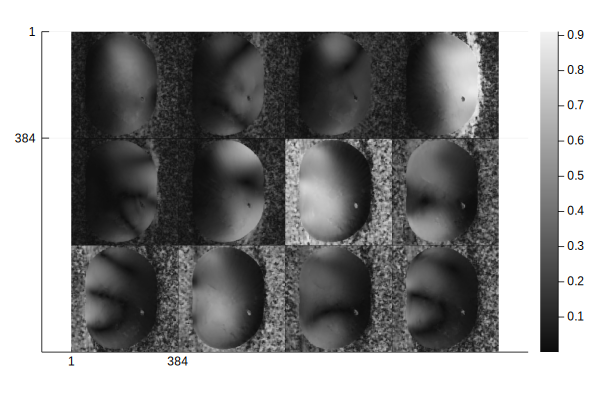

In [19]:
data = matread("../reproduce-l-s-dynamic-mri/data/abdomen_dce_ga.mat")
w, kdata, k, b1 = data["w"], data["kdata"], data["k"], data["b1"]
nspokes = 21 # number of spokes to be used per frame (Fibonacci number)
nx,ny,nc = size(b1)
nr,ntviews,nc = size(kdata)
nt = ntviews ÷ nspokes # number of frames

# crop the data according to the number of spokes per frame:
kdata = kdata[:,1:nt*nspokes,:]
k = k[:,1:nt*nspokes]
w = w[:,1:nt*nspokes]

# sort the data into a time-series of undersampled images:
kdatau = Array{Complex{Float64}}(undef, nr, nspokes, nc, nt)
ku = Array{Complex{Float64}}(undef, nr, nspokes, nt)
wu = Array{Complex{Float64}}(undef, nr, nspokes, nt)
for ii = 1:nt
    kdatau[:,:,:,ii] = kdata[:,(ii-1)*nspokes+1:ii*nspokes,:]
    ku[:,:,ii] = k[:,(ii-1)*nspokes+1:ii*nspokes]
    wu[:,:,ii] = w[:,(ii-1)*nspokes+1:ii*nspokes]
end

# prepare for system operator
ksp = reshape(ku, nr*nspokes, nt)
ksp3 = Array{Float64}(undef, nr*nspokes, 2, nt)
ksp3[:,1,:] = real(ksp)
ksp3[:,2,:] = imag(ksp)
om3 = ksp3*2*pi
wi3 = reshape(wu, nr*nspokes, nt)
M = size(ksp,1)

# normalize smap
b1c = b1 ./ sqrt.(sum(abs2, b1, dims=3))
jim(b1c, abswarn=false)

## 7.2 Test algorithms

In [20]:
E = getEnufft(b1c, ksp=ksp3, om=om3, wi=wi3, dType=ComplexF64)
d = permutedims(reshape(kdatau, nx*nspokes, nc, nt), [1 3 2])
recon_nufft = E' * d[:]
T = getT(nx, ny, nt, ComplexF64)
img_shape = (nx, ny, nt)

UndefVarError: UndefVarError: getEnufft not defined

**Run ISTA**

In [ ]:
@benchmark L, S, j_rankL_ista, j_cost_ista = PGM(d, E, T, img_shape = img_shape, scale_L = 0.0274/1.099,
    scale_S = 1/1.099, tscale = 1.3002, λ_L = 0.025, λ_S = 0.5*maximum(abs, recon_nufft), momentum=:ista)

**Run FISTA**

In [ ]:
@benchmark L, S, j_rankL_fista, j_cost_fista = PGM(d, E, T, img_shape = img_shape, scale_L = 0.0274/1.099,
    scale_S = 1/1.099, tscale = 1.3002, λ_L = 0.025, λ_S = 0.5*maximum(abs, recon_nufft), momentum=:fista)

**Run POGM**

In [ ]:
@benchmark L, S, j_rankL_pogm, j_cost_pogm = PGM(d, E, T, img_shape = img_shape, scale_L = 0.0274/1.099,
    scale_S = 1/1.099, tscale = 1.3002, λ_L = 0.025, λ_S = 0.5*maximum(abs, recon_nufft), momentum=:pogm)